In [1]:
import obonet
import pandas as pd
import argparse
import logging
import re
import numpy as np
from tqdm import tqdm
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)


def calculate_label(row):
    """
    Helper function to calculate the label for a given row.
    Returns the definition of the row with any text between brackets removed.
    """
    definition = row.get("def", None)

    # Remove any text between brackets, e.g., PubMed citations
    # Remove leading and trailing quotation marks
    if definition is not None:
        definition = re.sub(r'\s*\[.*?\]\s*', '', definition)
        definition = definition.strip('"')
        
    return definition

def process_synonyms(row)->dict:
    """extracts the synonyms of a GO Annotation

    :param row: Row of GO annotation dataset
    :type row: _type_
    :return: dict
    :rtype: lists of synonyms for relevant scopes
    """    
    if row is np.nan or not row:
        return {"synonym_exact": [], "synonym_narrow": [], "synonym_related": [], "synonym_broad": []}

    scopes = {"EXACT": [], "NARROW": [], "RELATED": [], "BROAD": []}
    for synonym in row:
        match = re.search(r'\"(.+?)\"\s+(EXACT|NARROW|RELATED|BROAD)\s+\[', synonym)
        if match:
            text, scope = match.groups()
            scopes[scope].append(text)

    return {
        "synonym_exact": scopes["EXACT"],
        "synonym_narrow": scopes["NARROW"],
        "synonym_related": scopes["RELATED"],
        "synonym_broad": scopes["BROAD"]
    }


def download_and_process_obo(url: str):
    """
    Download the OBO file from the specified URL and save the GO ID and label to a pickle.
    """
    logging.info("Downloading and processing OBO file...")

    # Load the .obo file directly from the URL into a networkx graph using obonet
    graph = obonet.read_obo(url, ignore_obsolete=False)

    # Convert the graph nodes (terms) into a pandas dataframe
    df = pd.DataFrame.from_dict(dict(graph.nodes(data=True)), orient='index')

    logging.info("Calculating labels...")
    # Create a new column called "label"
    df["label"] = df.apply(calculate_label, axis=1)

    # Filter the dataframe to retain only 'label', 'name' and 'synonym' columns, with the 'id' column as the index
    df_filtered = df[['label','name']+['is_obsolete']]

    obsolete_labels = set(df_filtered[df_filtered['is_obsolete']=="true"].index)
    used_labels = set(df_filtered.index) - obsolete_labels
    return used_labels,obsolete_labels

In [3]:

with open('Gene Ontology Data Archive.html','r') as handle:
    soup = BeautifulSoup(handle,'html.parser')

#Get all dates from releases during the last 10 years
dates=list(
    filter(lambda date: pd.to_datetime(date,format='%Y-%m-%d')>=pd.to_datetime('2014-06-01'),
        map(
            lambda x: x.get_text()[:-1],
            soup.findAll(lambda tag: tag.name =='a' and 'data-prefix' in tag.attrs)
            )
        )
    )

urls = [f'http://release.geneontology.org/{date}/ontology/go.obo' for date in dates]


prev_used_labels,prev_obsolete_labels = set(),set()

data = {'dates':[],'new_labels':[],'obsolete_labels':[],'used_labels':[]}

for date,url in tqdm(zip(dates,urls),total=len(urls)):
    used_labels,obsolete_labels = download_and_process_obo(url)
    print(url)
    data['dates'].append(date)

    new_labels = len(used_labels-prev_used_labels)
    obsolete_labels.update(prev_used_labels-used_labels) #augment obslete with other labels that simply don't show up
    new_obsolete_labels = len((obsolete_labels-prev_obsolete_labels))

    data['new_labels'].append(new_labels)
    data['obsolete_labels'].append(new_obsolete_labels)
    data['used_labels'].append(len(used_labels))


    print('new labels = ',new_labels)
    print('new obsolete = ',new_obsolete_labels)
    print('all labels = ',len(used_labels))

    prev_used_labels.update(used_labels)
    prev_obsolete_labels.update(obsolete_labels)


  0%|          | 0/113 [00:00<?, ?it/s]INFO:root:Downloading and processing OBO file...
INFO:root:Will decode content from http://release.geneontology.org/2024-04-24/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
  1%|          | 1/113 [00:08<16:07,  8.64s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2024-04-24/ontology/go.obo
new labels =  42255
new obsolete =  5570
all labels =  42255


INFO:root:Will decode content from http://release.geneontology.org/2024-04-18/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
  2%|▏         | 2/113 [00:17<15:58,  8.64s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2024-04-18/ontology/go.obo
new labels =  20
new obsolete =  4
all labels =  42271


INFO:root:Will decode content from http://release.geneontology.org/2024-03-28/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
  3%|▎         | 3/113 [00:25<15:45,  8.60s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2024-03-28/ontology/go.obo
new labels =  45
new obsolete =  4
all labels =  42312


INFO:root:Will decode content from http://release.geneontology.org/2024-01-17/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
  4%|▎         | 4/113 [00:34<15:55,  8.77s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2024-01-17/ontology/go.obo
new labels =  217
new obsolete =  87
all labels =  42442


INFO:root:Will decode content from http://release.geneontology.org/2023-11-15/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
  4%|▍         | 5/113 [00:43<15:33,  8.65s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2023-11-15/ontology/go.obo
new labels =  397
new obsolete =  69
all labels =  42769


INFO:root:Will decode content from http://release.geneontology.org/2023-10-09/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
  5%|▌         | 6/113 [00:51<14:59,  8.41s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2023-10-09/ontology/go.obo
new labels =  90
new obsolete =  21
all labels =  42837


INFO:root:Will decode content from http://release.geneontology.org/2023-07-27/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
  6%|▌         | 7/113 [00:59<14:54,  8.43s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2023-07-27/ontology/go.obo
new labels =  92
new obsolete =  40
all labels =  42887


INFO:root:Will decode content from http://release.geneontology.org/2023-06-11/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
  7%|▋         | 8/113 [01:08<15:03,  8.61s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2023-06-11/ontology/go.obo
new labels =  101
new obsolete =  35
all labels =  42950


INFO:root:Will decode content from http://release.geneontology.org/2023-05-10/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
  8%|▊         | 9/113 [01:17<14:46,  8.52s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2023-05-10/ontology/go.obo
new labels =  102
new obsolete =  44
all labels =  43008


INFO:root:Will decode content from http://release.geneontology.org/2023-04-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
  9%|▉         | 10/113 [01:25<14:26,  8.41s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2023-04-01/ontology/go.obo
new labels =  102
new obsolete =  17
all labels =  43093


INFO:root:Will decode content from http://release.geneontology.org/2023-03-06/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 10%|▉         | 11/113 [01:33<14:08,  8.31s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2023-03-06/ontology/go.obo
new labels =  16
new obsolete =  14
all labels =  43096


INFO:root:Will decode content from http://release.geneontology.org/2023-01-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 11%|█         | 12/113 [01:41<14:11,  8.43s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2023-01-01/ontology/go.obo
new labels =  219
new obsolete =  67
all labels =  43248


INFO:root:Will decode content from http://release.geneontology.org/2022-12-04/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 12%|█▏        | 13/113 [01:50<13:53,  8.34s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-12-04/ontology/go.obo
new labels =  35
new obsolete =  10
all labels =  43272


INFO:root:Will decode content from http://release.geneontology.org/2022-11-03/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 12%|█▏        | 14/113 [01:58<13:39,  8.28s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-11-03/ontology/go.obo
new labels =  39
new obsolete =  8
all labels =  43303


INFO:root:Will decode content from http://release.geneontology.org/2022-10-07/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 13%|█▎        | 15/113 [02:06<13:30,  8.27s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-10-07/ontology/go.obo
new labels =  75
new obsolete =  49
all labels =  43329


INFO:root:Will decode content from http://release.geneontology.org/2022-09-19/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 14%|█▍        | 16/113 [02:14<13:09,  8.14s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-09-19/ontology/go.obo
new labels =  24
new obsolete =  18
all labels =  43335


INFO:root:Will decode content from http://release.geneontology.org/2022-07-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 15%|█▌        | 17/113 [02:22<12:59,  8.12s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-07-01/ontology/go.obo
new labels =  282
new obsolete =  59
all labels =  43558


INFO:root:Will decode content from http://release.geneontology.org/2022-06-15/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 16%|█▌        | 18/113 [02:30<12:53,  8.15s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-06-15/ontology/go.obo
new labels =  78
new obsolete =  23
all labels =  43613


INFO:root:Will decode content from http://release.geneontology.org/2022-05-16/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 17%|█▋        | 19/113 [02:39<12:53,  8.23s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-05-16/ontology/go.obo
new labels =  72
new obsolete =  37
all labels =  43648


INFO:root:Will decode content from http://release.geneontology.org/2022-03-22/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 18%|█▊        | 20/113 [02:47<12:40,  8.18s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-03-22/ontology/go.obo
new labels =  103
new obsolete =  49
all labels =  43699


INFO:root:Will decode content from http://release.geneontology.org/2022-03-10/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 19%|█▊        | 21/113 [02:55<12:31,  8.17s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-03-10/ontology/go.obo
new labels =  13
new obsolete =  8
all labels =  43704


INFO:root:Will decode content from http://release.geneontology.org/2022-01-13/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 19%|█▉        | 22/113 [03:03<12:30,  8.25s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-01-13/ontology/go.obo
new labels =  116
new obsolete =  34
all labels =  43786


INFO:root:Will decode content from http://release.geneontology.org/2021-12-15/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 20%|██        | 23/113 [03:11<12:20,  8.22s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-12-15/ontology/go.obo
new labels =  12
new obsolete =  8
all labels =  43789


INFO:root:Will decode content from http://release.geneontology.org/2021-11-16/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 21%|██        | 24/113 [03:20<12:15,  8.26s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-11-16/ontology/go.obo
new labels =  37
new obsolete =  35
all labels =  43791


INFO:root:Will decode content from http://release.geneontology.org/2021-10-26/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 22%|██▏       | 25/113 [03:28<12:02,  8.21s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-10-26/ontology/go.obo
new labels =  50
new obsolete =  9
all labels =  43832


INFO:root:Will decode content from http://release.geneontology.org/2021-09-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 23%|██▎       | 26/113 [03:37<12:09,  8.38s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-09-01/ontology/go.obo
new labels =  41
new obsolete =  22
all labels =  43850


INFO:root:Will decode content from http://release.geneontology.org/2021-08-18/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 24%|██▍       | 27/113 [03:45<11:51,  8.28s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-08-18/ontology/go.obo
new labels =  36
new obsolete =  8
all labels =  43878


INFO:root:Will decode content from http://release.geneontology.org/2021-07-02/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 25%|██▍       | 28/113 [03:53<11:46,  8.31s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-07-02/ontology/go.obo
new labels =  68
new obsolete =  29
all labels =  43917


INFO:root:Will decode content from http://release.geneontology.org/2021-06-16/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 26%|██▌       | 29/113 [04:01<11:28,  8.20s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-06-16/ontology/go.obo
new labels =  18
new obsolete =  18
all labels =  43917


INFO:root:Will decode content from http://release.geneontology.org/2021-05-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 27%|██▋       | 30/113 [04:09<11:14,  8.12s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-05-01/ontology/go.obo
new labels =  100
new obsolete =  28
all labels =  43987


INFO:root:Will decode content from http://release.geneontology.org/2021-02-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 27%|██▋       | 31/113 [04:17<11:04,  8.11s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-02-01/ontology/go.obo
new labels =  189
new obsolete =  89
all labels =  44085


INFO:root:Will decode content from http://release.geneontology.org/2021-01-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 28%|██▊       | 32/113 [04:25<10:55,  8.10s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-01-01/ontology/go.obo
new labels =  29
new obsolete =  23
all labels =  44091


INFO:root:Will decode content from http://release.geneontology.org/2020-12-08/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 29%|██▉       | 33/113 [04:33<10:45,  8.07s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-12-08/ontology/go.obo
new labels =  36
new obsolete =  10
all labels =  44117


INFO:root:Will decode content from http://release.geneontology.org/2020-11-17/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 30%|███       | 34/113 [04:41<10:36,  8.05s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-11-17/ontology/go.obo
new labels =  62
new obsolete =  9
all labels =  44167


INFO:root:Will decode content from http://release.geneontology.org/2020-10-09/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 31%|███       | 35/113 [04:49<10:27,  8.05s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-10-09/ontology/go.obo
new labels =  144
new obsolete =  45
all labels =  44264


INFO:root:Will decode content from http://release.geneontology.org/2020-09-10/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 32%|███▏      | 36/113 [04:57<10:21,  8.08s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-09-10/ontology/go.obo
new labels =  53
new obsolete =  44
all labels =  44272


INFO:root:Will decode content from http://release.geneontology.org/2020-08-10/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 33%|███▎      | 37/113 [05:06<10:21,  8.18s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-08-10/ontology/go.obo
new labels =  36
new obsolete =  46
all labels =  44262


INFO:root:Will decode content from http://release.geneontology.org/2020-07-16/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 34%|███▎      | 38/113 [05:14<10:12,  8.17s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-07-16/ontology/go.obo
new labels =  3
new obsolete =  21
all labels =  44244


INFO:root:Will decode content from http://release.geneontology.org/2020-06-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 35%|███▍      | 39/113 [05:22<10:12,  8.27s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-06-01/ontology/go.obo
new labels =  205
new obsolete =  38
all labels =  44411


INFO:root:Will decode content from http://release.geneontology.org/2020-05-02/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 35%|███▌      | 40/113 [05:30<09:53,  8.13s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-05-02/ontology/go.obo
new labels =  114
new obsolete =  16
all labels =  44508


INFO:root:Will decode content from http://release.geneontology.org/2020-04-23/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 36%|███▋      | 41/113 [05:38<09:41,  8.07s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-04-23/ontology/go.obo
new labels =  17
new obsolete =  6
all labels =  44519


INFO:root:Will decode content from http://release.geneontology.org/2020-03-25/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 37%|███▋      | 42/113 [05:46<09:32,  8.07s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-03-25/ontology/go.obo
new labels =  45
new obsolete =  32
all labels =  44531


INFO:root:Will decode content from http://release.geneontology.org/2020-02-26/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 38%|███▊      | 43/113 [05:54<09:29,  8.13s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-02-26/ontology/go.obo
new labels =  75
new obsolete =  27
all labels =  44579


INFO:root:Will decode content from http://release.geneontology.org/2020-01-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 39%|███▉      | 44/113 [06:03<09:23,  8.16s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-01-01/ontology/go.obo
new labels =  191
new obsolete =  64
all labels =  44700


INFO:root:Will decode content from http://release.geneontology.org/2019-12-09/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 40%|███▉      | 45/113 [06:10<09:07,  8.06s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-12-09/ontology/go.obo
new labels =  6
new obsolete =  31
all labels =  44674


INFO:root:Will decode content from http://release.geneontology.org/2019-11-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 41%|████      | 46/113 [06:18<08:54,  7.98s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-11-01/ontology/go.obo
new labels =  55
new obsolete =  79
all labels =  44650


INFO:root:Will decode content from http://release.geneontology.org/2019-10-07/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 42%|████▏     | 47/113 [06:26<08:45,  7.96s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-10-07/ontology/go.obo
new labels =  99
new obsolete =  16
all labels =  44733


INFO:root:Will decode content from http://release.geneontology.org/2019-07-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 42%|████▏     | 48/113 [06:34<08:38,  7.98s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-07-01/ontology/go.obo
new labels =  271
new obsolete =  56
all labels =  44945


INFO:root:Will decode content from http://release.geneontology.org/2019-06-09/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 43%|████▎     | 49/113 [06:42<08:32,  8.01s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-06-09/ontology/go.obo
new labels =  68
new obsolete =  19
all labels =  44990


INFO:root:Will decode content from http://release.geneontology.org/2019-06-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 44%|████▍     | 50/113 [06:50<08:26,  8.04s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-06-01/ontology/go.obo
new labels =  19
new obsolete =  3
all labels =  45006


INFO:root:Will decode content from http://release.geneontology.org/2019-05-09/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 45%|████▌     | 51/113 [06:58<08:14,  7.97s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-05-09/ontology/go.obo
new labels =  60
new obsolete =  41
all labels =  45024


INFO:root:Will decode content from http://release.geneontology.org/2019-04-17/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 46%|████▌     | 52/113 [07:06<08:03,  7.92s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-04-17/ontology/go.obo
new labels =  11
new obsolete =  17
all labels =  45017


INFO:root:Will decode content from http://release.geneontology.org/2019-03-18/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 47%|████▋     | 53/113 [07:14<07:54,  7.91s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-03-18/ontology/go.obo
new labels =  18
new obsolete =  21
all labels =  45006


INFO:root:Will decode content from http://release.geneontology.org/2019-03-10/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 48%|████▊     | 54/113 [07:22<07:44,  7.88s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-03-10/ontology/go.obo
new labels =  23
new obsolete =  2
all labels =  45027


INFO:root:Will decode content from http://release.geneontology.org/2019-02-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 49%|████▊     | 55/113 [07:30<07:40,  7.94s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-02-01/ontology/go.obo
new labels =  6
new obsolete =  20
all labels =  45013


INFO:root:Will decode content from http://release.geneontology.org/2019-01-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 50%|████▉     | 56/113 [07:38<07:35,  7.99s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-01-01/ontology/go.obo
new labels =  0
new obsolete =  7
all labels =  45003


INFO:root:Will decode content from http://release.geneontology.org/2018-12-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 50%|█████     | 57/113 [07:45<07:19,  7.85s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-12-01/ontology/go.obo
new labels =  37
new obsolete =  8
all labels =  45032


INFO:root:Will decode content from http://release.geneontology.org/2018-11-15/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 51%|█████▏    | 58/113 [07:53<07:06,  7.76s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-11-15/ontology/go.obo
new labels =  1
new obsolete =  22
all labels =  45007


INFO:root:Will decode content from http://release.geneontology.org/2018-10-08/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 52%|█████▏    | 59/113 [08:01<07:10,  7.98s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-10-08/ontology/go.obo
new labels =  62
new obsolete =  24
all labels =  45043


INFO:root:Will decode content from http://release.geneontology.org/2018-10-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 53%|█████▎    | 60/113 [08:10<07:06,  8.04s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-10-01/ontology/go.obo
new labels =  6
new obsolete =  5
all labels =  45044


INFO:root:Will decode content from http://release.geneontology.org/2018-09-05/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 54%|█████▍    | 61/113 [08:18<06:57,  8.04s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-09-05/ontology/go.obo
new labels =  17
new obsolete =  28
all labels =  45032


INFO:root:Will decode content from http://release.geneontology.org/2018-08-09/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 55%|█████▍    | 62/113 [08:26<06:59,  8.22s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-08-09/ontology/go.obo
new labels =  4
new obsolete =  33
all labels =  45003


INFO:root:Will decode content from http://release.geneontology.org/2018-07-02/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 56%|█████▌    | 63/113 [08:34<06:49,  8.19s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-07-02/ontology/go.obo
new labels =  22
new obsolete =  77
all labels =  44947


INFO:root:Will decode content from http://release.geneontology.org/2018-06-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 57%|█████▋    | 64/113 [08:43<06:44,  8.26s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-06-01/ontology/go.obo
new labels =  37
new obsolete =  17
all labels =  44968


INFO:root:Will decode content from http://release.geneontology.org/2018-05-20/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 58%|█████▊    | 65/113 [08:51<06:40,  8.35s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-05-20/ontology/go.obo
new labels =  14
new obsolete =  10
all labels =  44970


INFO:root:Will decode content from http://release.geneontology.org/2018-04-02/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 58%|█████▊    | 66/113 [09:00<06:32,  8.36s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-04-02/ontology/go.obo
new labels =  41
new obsolete =  87
all labels =  44922


INFO:root:Will decode content from http://release.geneontology.org/2018-03-10/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 59%|█████▉    | 67/113 [09:08<06:23,  8.34s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-03-10/ontology/go.obo
new labels =  43
new obsolete =  26
all labels =  44939


INFO:root:Will decode content from http://release.geneontology.org/2018-03-06/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 60%|██████    | 68/113 [09:16<06:16,  8.37s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-03-06/ontology/go.obo
new labels =  6
new obsolete =  3
all labels =  44942


INFO:root:Will decode content from http://release.geneontology.org/2018-02-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 61%|██████    | 69/113 [09:25<06:12,  8.46s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-02-01/ontology/go.obo
new labels =  145
new obsolete =  110
all labels =  44970


INFO:root:Will decode content from http://release.geneontology.org/2018-01-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 62%|██████▏   | 70/113 [09:34<06:06,  8.52s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-01-01/ontology/go.obo
new labels =  53
new obsolete =  22
all labels =  45001


INFO:root:Will decode content from http://release.geneontology.org/2017-12-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 63%|██████▎   | 71/113 [09:43<06:00,  8.59s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-12-01/ontology/go.obo
new labels =  14
new obsolete =  56
all labels =  44955


INFO:root:Will decode content from http://release.geneontology.org/2017-11-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 64%|██████▎   | 72/113 [09:51<05:55,  8.67s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-11-01/ontology/go.obo
new labels =  60
new obsolete =  44
all labels =  44969


INFO:root:Will decode content from http://release.geneontology.org/2017-10-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 65%|██████▍   | 73/113 [10:00<05:47,  8.70s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-10-01/ontology/go.obo
new labels =  51
new obsolete =  44
all labels =  44977


INFO:root:Will decode content from http://release.geneontology.org/2017-09-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 65%|██████▌   | 74/113 [10:09<05:39,  8.70s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-09-01/ontology/go.obo
new labels =  12
new obsolete =  51
all labels =  44931


INFO:root:Will decode content from http://release.geneontology.org/2017-08-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 66%|██████▋   | 75/113 [10:18<05:30,  8.70s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-08-01/ontology/go.obo
new labels =  31
new obsolete =  64
all labels =  44890


INFO:root:Will decode content from http://release.geneontology.org/2017-07-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 67%|██████▋   | 76/113 [10:26<05:21,  8.68s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-07-01/ontology/go.obo
new labels =  49
new obsolete =  81
all labels =  44844


INFO:root:Will decode content from http://release.geneontology.org/2017-06-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 68%|██████▊   | 77/113 [10:35<05:15,  8.77s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-06-01/ontology/go.obo
new labels =  5
new obsolete =  211
all labels =  44616


INFO:root:Will decode content from http://release.geneontology.org/2017-05-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 69%|██████▉   | 78/113 [10:44<05:08,  8.82s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-05-01/ontology/go.obo
new labels =  6
new obsolete =  78
all labels =  44538


INFO:root:Will decode content from http://release.geneontology.org/2017-04-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 70%|██████▉   | 79/113 [10:53<04:57,  8.74s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-04-01/ontology/go.obo
new labels =  44
new obsolete =  49
all labels =  44528


INFO:root:Will decode content from http://release.geneontology.org/2017-03-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 71%|███████   | 80/113 [11:01<04:42,  8.56s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-03-01/ontology/go.obo
new labels =  46
new obsolete =  111
all labels =  44449


INFO:root:Will decode content from http://release.geneontology.org/2017-02-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 72%|███████▏  | 81/113 [11:09<04:34,  8.57s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-02-01/ontology/go.obo
new labels =  15
new obsolete =  132
all labels =  44307


INFO:root:Will decode content from http://release.geneontology.org/2017-01-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 73%|███████▎  | 82/113 [11:18<04:27,  8.62s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-01-01/ontology/go.obo
new labels =  13
new obsolete =  317
all labels =  43973


INFO:root:Will decode content from http://release.geneontology.org/2016-12-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 73%|███████▎  | 83/113 [11:27<04:21,  8.71s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-12-01/ontology/go.obo
new labels =  6
new obsolete =  79
all labels =  43896


INFO:root:Will decode content from http://release.geneontology.org/2016-11-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 74%|███████▍  | 84/113 [11:35<04:07,  8.55s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-11-01/ontology/go.obo
new labels =  8
new obsolete =  244
all labels =  43647


INFO:root:Will decode content from http://release.geneontology.org/2016-10-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 75%|███████▌  | 85/113 [11:44<03:58,  8.52s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-10-01/ontology/go.obo
new labels =  17
new obsolete =  211
all labels =  43435


INFO:root:Will decode content from http://release.geneontology.org/2016-09-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 76%|███████▌  | 86/113 [11:53<03:54,  8.67s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-09-01/ontology/go.obo
new labels =  7
new obsolete =  132
all labels =  43286


INFO:root:Will decode content from http://release.geneontology.org/2016-08-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 77%|███████▋  | 87/113 [12:01<03:45,  8.66s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-08-01/ontology/go.obo
new labels =  9
new obsolete =  165
all labels =  43127


INFO:root:Will decode content from http://release.geneontology.org/2016-07-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 78%|███████▊  | 88/113 [12:10<03:35,  8.61s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-07-01/ontology/go.obo
new labels =  0
new obsolete =  76
all labels =  43049


INFO:root:Will decode content from http://release.geneontology.org/2016-06-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 79%|███████▉  | 89/113 [12:19<03:27,  8.65s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-06-01/ontology/go.obo
new labels =  5
new obsolete =  184
all labels =  42819


INFO:root:Will decode content from http://release.geneontology.org/2016-05-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 80%|███████▉  | 90/113 [12:27<03:15,  8.51s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-05-01/ontology/go.obo
new labels =  21
new obsolete =  106
all labels =  42716


INFO:root:Will decode content from http://release.geneontology.org/2016-04-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 81%|████████  | 91/113 [12:35<03:04,  8.36s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-04-01/ontology/go.obo
new labels =  9
new obsolete =  205
all labels =  42511


INFO:root:Will decode content from http://release.geneontology.org/2016-03-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 81%|████████▏ | 92/113 [12:43<02:54,  8.30s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-03-01/ontology/go.obo
new labels =  14
new obsolete =  173
all labels =  42341


INFO:root:Will decode content from http://release.geneontology.org/2016-02-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 82%|████████▏ | 93/113 [12:51<02:44,  8.20s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-02-01/ontology/go.obo
new labels =  2
new obsolete =  58
all labels =  42277


INFO:root:Will decode content from http://release.geneontology.org/2016-01-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 83%|████████▎ | 94/113 [13:00<02:38,  8.33s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-01-01/ontology/go.obo
new labels =  0
new obsolete =  164
all labels =  42108


INFO:root:Will decode content from http://release.geneontology.org/2015-12-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 84%|████████▍ | 95/113 [13:08<02:27,  8.22s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-12-01/ontology/go.obo
new labels =  6
new obsolete =  67
all labels =  42045


INFO:root:Will decode content from http://release.geneontology.org/2015-11-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 85%|████████▍ | 96/113 [13:16<02:18,  8.17s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-11-01/ontology/go.obo
new labels =  1
new obsolete =  87
all labels =  41952


INFO:root:Will decode content from http://release.geneontology.org/2015-10-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 86%|████████▌ | 97/113 [13:24<02:10,  8.15s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-10-01/ontology/go.obo
new labels =  0
new obsolete =  109
all labels =  41833


INFO:root:Will decode content from http://release.geneontology.org/2015-09-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 87%|████████▋ | 98/113 [13:32<02:01,  8.10s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-09-01/ontology/go.obo
new labels =  0
new obsolete =  92
all labels =  41733


INFO:root:Will decode content from http://release.geneontology.org/2015-08-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 88%|████████▊ | 99/113 [13:40<01:53,  8.08s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-08-01/ontology/go.obo
new labels =  0
new obsolete =  137
all labels =  41589


INFO:root:Will decode content from http://release.geneontology.org/2015-07-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 88%|████████▊ | 100/113 [13:48<01:44,  8.03s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-07-01/ontology/go.obo
new labels =  14
new obsolete =  165
all labels =  41423


INFO:root:Will decode content from http://release.geneontology.org/2015-06-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 89%|████████▉ | 101/113 [13:55<01:34,  7.85s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-06-01/ontology/go.obo
new labels =  6
new obsolete =  192
all labels =  41232


INFO:root:Will decode content from http://release.geneontology.org/2015-05-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 90%|█████████ | 102/113 [14:02<01:24,  7.69s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-05-01/ontology/go.obo
new labels =  2
new obsolete =  151
all labels =  41077


INFO:root:Will decode content from http://release.geneontology.org/2015-04-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 91%|█████████ | 103/113 [14:10<01:16,  7.66s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-04-01/ontology/go.obo
new labels =  3
new obsolete =  97
all labels =  40911


INFO:root:Will decode content from http://release.geneontology.org/2015-03-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 92%|█████████▏| 104/113 [14:17<01:07,  7.53s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-03-01/ontology/go.obo
new labels =  5
new obsolete =  190
all labels =  40705


INFO:root:Will decode content from http://release.geneontology.org/2015-02-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 93%|█████████▎| 105/113 [14:25<01:01,  7.64s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-02-01/ontology/go.obo
new labels =  44
new obsolete =  158
all labels =  40590


INFO:root:Will decode content from http://release.geneontology.org/2015-01-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 94%|█████████▍| 106/113 [14:32<00:52,  7.56s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-01-01/ontology/go.obo
new labels =  17
new obsolete =  132
all labels =  40470


INFO:root:Will decode content from http://release.geneontology.org/2014-12-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 95%|█████████▍| 107/113 [14:40<00:45,  7.54s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2014-12-01/ontology/go.obo
new labels =  6
new obsolete =  127
all labels =  40338


INFO:root:Will decode content from http://release.geneontology.org/2014-11-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 96%|█████████▌| 108/113 [14:47<00:37,  7.48s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2014-11-01/ontology/go.obo
new labels =  1
new obsolete =  159
all labels =  40162


INFO:root:Will decode content from http://release.geneontology.org/2014-10-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 96%|█████████▋| 109/113 [14:55<00:30,  7.51s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2014-10-01/ontology/go.obo
new labels =  4
new obsolete =  133
all labels =  40021


INFO:root:Will decode content from http://release.geneontology.org/2014-09-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 97%|█████████▋| 110/113 [15:03<00:23,  7.71s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2014-09-01/ontology/go.obo
new labels =  1
new obsolete =  155
all labels =  39852


INFO:root:Will decode content from http://release.geneontology.org/2014-08-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 98%|█████████▊| 111/113 [15:10<00:15,  7.62s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2014-08-01/ontology/go.obo
new labels =  1
new obsolete =  231
all labels =  39601


INFO:root:Will decode content from http://release.geneontology.org/2014-07-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
 99%|█████████▉| 112/113 [15:18<00:07,  7.58s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2014-07-01/ontology/go.obo
new labels =  3
new obsolete =  156
all labels =  39427


INFO:root:Will decode content from http://release.geneontology.org/2014-06-01/ontology/go.obo using utf-8 charset.
INFO:root:Calculating labels...
100%|██████████| 113/113 [15:25<00:00,  8.19s/it]

http://release.geneontology.org/2014-06-01/ontology/go.obo
new labels =  0
new obsolete =  91
all labels =  39326


In [11]:
df

,new_labels,obsolete_labels,used_labels
dates,,,
2024-04-18,20,4,42271
2024-03-28,45,4,42312
2024-01-17,217,87,42442
2023-11-15,397,69,42769
2023-10-09,90,21,42837
...,...,...,...
2014-10-01,4,133,40021
2014-09-01,1,155,39852
2014-08-01,1,231,39601


In [7]:
df = pd.DataFrame(data).set_index('dates')
df.index = pd.to_datetime(df.index)
df.to_parquet('go_annotations_by_release.parquet')

In [2]:
df = pd.read_parquet('go_annotations_by_release.parquet')

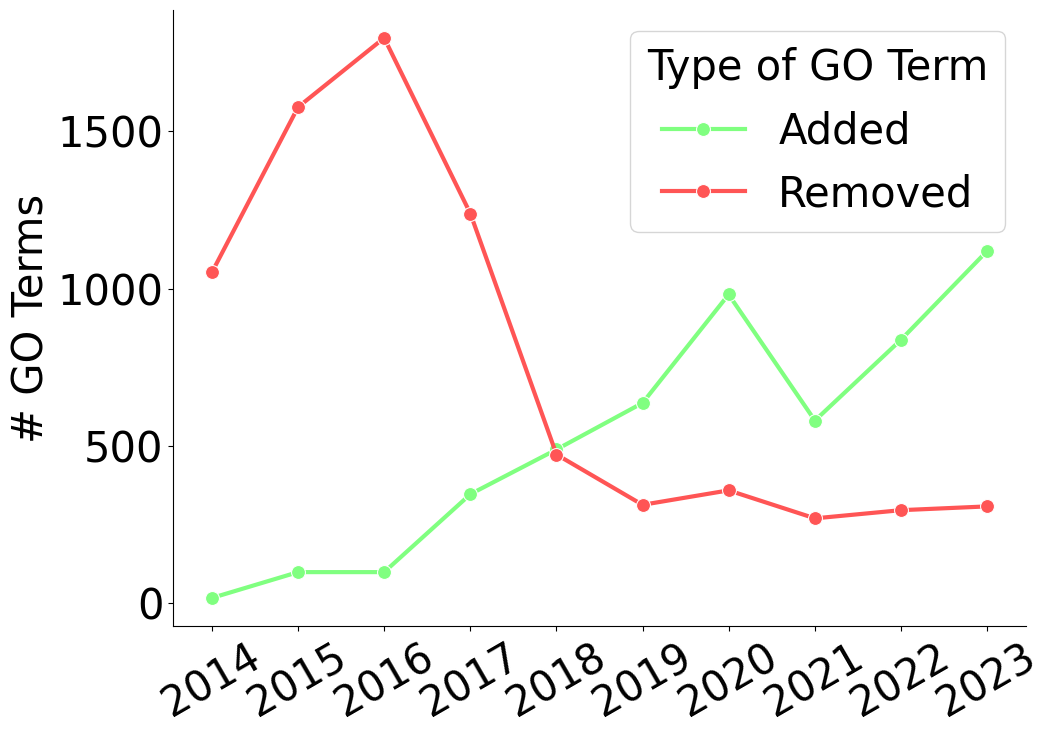

In [7]:
plt.rcParams['font.size'] = 30
# plt.rcParams['font.weight'] = 'bold'
# plt.rcParams['axes.labelweight']='bold'

df = df.iloc[1:]
fig,ax = plt.subplots(figsize=(11,8))
sns_data = df.groupby([pd.Grouper(level='dates',freq='YS')])[['new_labels','obsolete_labels']]\
    .sum()\
    .melt(ignore_index=False,
          var_name='Type of GO Term',
          value_name='# GO Terms')\
    .replace({'new_labels':'Added','obsolete_labels':'Removed'})

palette = {'Added':'#80ff80','Removed':'#ff5555'}
sns.lineplot(data = sns_data,
             x = 'dates',
             y = '# GO Terms',
             hue='Type of GO Term',
             marker='o',
             palette=palette,
             linewidth=3,
             markersize=10)
plt.xlabel('')
plt.xticks(rotation=30)
sns.despine()
plt.savefig(f'deleted_added_go_terms.png', format='png', dpi=1200,bbox_inches='tight')
plt.show()


In [48]:
for i in a[0].children:
    for j in i:
        print(j)





<tr>
<th>Folders and files</th>
<th>Folder</th>
<th>Last Modified</th>
<th>Timestamp</th>
<th style="width:200px">Size</th>
</tr>








In [54]:
soup.find_all('td',class_='sorting_2')

[]

In [56]:
td_tags = soup.find_all('td', class_='sorting_2')
[td.find('a').get_text() for td in td_tags if td.find('a')]

[]